<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# News Article Classification


Today, you are a machine learning engineer at [Upday](https://www.upday.com/home), a news app. The engine behind the app processes almost 100k news articles every day in many languages and context. In order to connect people with the right content, we need to know what the articles are about. 

The job here is to build a classifier that identify the category of an article accurately that will be fed into the recommendation algorithms of the app for better personalized content for the readers. 

You will first train a Transformer from scratch; then fine-tune a pre-trained Transformer model for text classification using 🤗; and compare performances using the same test data set.

## Learning objectives


By the end of this session, you will be able to:
- Understand how Transformer models work
- Build a Transformer model for text classification from scratch
- Fine-tune a pre-trained Transformer model for text classification using 🤗 

# Task 1. Prepare the data

1. [20 news groups data](http://qwone.com/~jason/20Newsgroups/) is one of the standard datasets in the `scikit-learn`. The 20 newsgroups dataset comprises around 18k newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the two datasets is based upon messages posted before and after a specific date.

    Take a read on its [usage](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset) and load the training and testing datasets into `train` and `test` respectively via `fetch_20newsgroups`.

In [1]:
NUM_LABELS = 20

In [2]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups( subset='train', shuffle=True, random_state=42)
test = fetch_20newsgroups( subset='test', shuffle=True, random_state=42)

1. Explore the data. For example, what is the data type of `train` and `test`? What is the data type of `train['data']`? What is in `train['target_names']`? 

    YOUR ANSWER HERE

In [3]:
type(train)

sklearn.utils.Bunch

In [4]:
#import pandas as pd
#train = pd.DataFrame(train)
type(train['data'])

list

1. Train / validation / test splits. 

    There are four keys in each data set and we need "data" (the text) and "target" (the category). Extract the "data" and create a `pd.Series` named `X`; and extract the "target" and create a `pd.Series` named `y`. Do the same for the `test` data set, named `X_test` and `y_test`, respectively.

In [5]:
import pandas as pd

X, y = pd.Series(train['data']),pd.Series(train['target'])  #
X_test, y_test = pd.Series(test['data']),pd.Series(test['target'])  #train_test_split(, test_size=0.20, random_state=42)

In [6]:
y_test.shape

(7532,)

Now split `X` and `y` into training and validation sets. Use `train_test_split` from `sklearn.model_selection` to split the data; save 10% of the data for validation and set the random state to 19.

In [7]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=19)


In [8]:
assert y_train.shape == (10182,)
assert y_valid.shape == (1132,)
assert y_test.shape == (7532,)

1. Convert categorical labels into dummy variables. 

    Use `pd.get_dummies` to convert labels into dummy variables for `y_train`, `y_valid`, `y_test`.

In [9]:
y_train = pd.get_dummies(y_train)# YOUR CODE HERE
y_valid = pd.get_dummies(y_valid)# YOUR CODE HERE
y_test = pd.get_dummies(y_test)# YOUR CODE HERE

In [10]:
assert y_train.shape == (10182, NUM_LABELS)
assert y_valid.shape == (1132, NUM_LABELS)
assert y_test.shape == (7532, NUM_LABELS)


# Task 2. Attention is all you need

Recently most of the natural language processing tasks are being dominated by the `Transformer` architecture, introduced in [Attention Is All You Need](https://arxiv.org/abs/1706.03762), which used a simple mechanism called `Neural Attention` as one of its building blocks. As the title suggests this architecture didn't require any recurrent layer. We now build a text classification using Attention and Positional Embeddings.

1. Transformer (attention) Block. 

    The concept of `Neural Attention` is fairly simple; i.e., not all input information seen by a model is equally important to the task at hand. Although this concept has been utilized at various different places as well, e.g., max pooling in ConvNets, but the kind of attention we are looking for should be `context aware`.

    The attention mechanism allows output to focus attention on input while producing output while the self-attention model allows inputs to interact with each other; in other words, calculate attention of all other inputs with respect to one input.

    In the paper, the authors proposed another type of attention mechanism called multi-headed attention which refers to the fact that the outer space of the self attention layer gets factored into a set of independent sub-spaces learned separately, where each subspace is called a "head". **You need to implement the multi-head attention layer**, supplying values for two parameters: `num_heads` and `key_dim`.

    There is a learnable dense projection present after the multi-head attention which enables the layer to actually learn something, as opposed to being a purely stateless transformation. **You need to implement `dense_proj`**, use the `tf.keras.Sequential` to stack two dense layers: 
    
        1. first dense layer with `dense_dim` units and activation function `relu`;
        2. second dense layer with `embed_dim` units and no activation function.

In [11]:
from tensorflow.keras import layers as L
import tensorflow as tf
from tensorflow import keras

class TransformerBlock(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)  # YOUR CODE HERE
        self.dense_proj = keras.Sequential([L.Dense(dense_dim,activation=tf.nn.relu),L.Dense(embed_dim),])# YOUR CODE HERE
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
        super().__init__(**kwargs)
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

1. Positional embedding. 

    The idea behind Positional Encoding is fairly simple as well: to give the model access to token order information, therefore we are going to add the token's position in the sentence to each word embedding.

    Thus, one input word embedding will have two components: the usual token vector representing the token independent of any specific context, and a position vector representing the position of the token in the current sequence.

In [12]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        self.token_embeddings = L.Embedding(input_dim, output_dim)# YOUR CODE HERE
        self.position_embeddings = L.Embedding(sequence_length, output_dim) # YOUR CODE HERE
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__(**kwargs)
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

1. Define some constants to parameterize the model.

In [13]:
VOCAB_SIZE = 10_000
EMBED_DIM = 256
DENSE_DIM = 32
NUM_HEADS = 2
MAX_LEN = 256

1. Tokenizer. 
    
    The tokenizer is a simple tool to convert a text into a sequence of tokens. It is used to convert the training data into a sequence of integers, which are then used as input to the model. 

    Use `Tokenizer` to create a tokenizer for the training data. Set the `num_words` parameter to the number of words to keep in the vocabulary, and `oov_token` to be `"<unk>"`.

In [14]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= MAX_LEN ,oov_token="<unk>") # YOUR CODE HERE
tokenizer.fit_on_texts(X_train)

1. Pad the sequences. 
    
    The tokenizer outputs a sequence of integers, which are then used as input to the model. However, the model expects a sequence of fixed length. To pad the sequences to the same length, use `sequence.pad_sequences` from `keras.preprocessing`.

    Complete function `preprocess` below to 1) tokenize the texts 2) pad the sequences to the same length.

In [15]:
#from keras.preprocessing import sequence
from keras.utils import pad_sequences

def preprocess(texts, tokenizer, maxlen:int = MAX_LEN):
    seqs = tokenizer.texts_to_sequences(texts)  # YOUR CODE HERE
    tokenized_text = pad_sequences(seqs, maxlen=MAX_LEN) # YOUR CODE HERE
    return tokenized_text

1. Preprocess the data. 
    
    Use `preprocess` to preprocess the training, validation, and test data.

In [16]:
X_train = preprocess(X_train, tokenizer,MAX_LEN)# YOUR CODE HERE
X_valid = preprocess(X_valid, tokenizer,MAX_LEN)# YOUR CODE HERE
X_test  = preprocess(X_test, tokenizer,MAX_LEN)# YOUR CODE HERE

In [17]:
X_train

array([[ 0,  0,  0, ..., 14,  1,  1],
       [ 0,  0,  0, ..., 50,  1,  1],
       [ 0,  0,  0, ...,  1, 13,  1],
       ...,
       [ 0,  0,  0, ..., 23,  1,  1],
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 1,  2,  1, ...,  1,  1, 32]], dtype=int32)

1. Define the model with the following architecture: 

    * Input Layer
    * Positional Embeddings
    * Transformer Block
    * Pooling
    * Dropout
    * Output Layer

    If you are not familiar with keras functional API, take a read [here](https://keras.io/guides/functional_api/).

In [18]:
inputs = keras.Input(shape=(None, ), dtype="int64")

x = PositionalEmbedding(sequence_length = MAX_LEN, input_dim = VOCAB_SIZE, output_dim =EMBED_DIM)(inputs)
x = TransformerBlock(EMBED_DIM, DENSE_DIM,num_heads=NUM_HEADS)(x)
 
x = L.GlobalMaxPooling1D()(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(20, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        2625536   
 ionalEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, None, 256)        543776    
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

1. Compile model. 

    Use 'adam' for the optimizer and accuracy for metrics, supply the correct value for loss. 

In [20]:
model.compile(
    optimizer='adam', # YOUR CODE HERE
    loss='categorical_crossentropy', # YOUR CODE HERE
    metrics='accuracy' # YOUR CODE HERE
)

1. Add [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) and [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) to stop training if the model does not improve a set metric after a given number of epochs. 

    Create an `EarlyStopping` object named `es` to stop training if the validation loss does not improve after 5 epochs. Set verbose to display messages when the callback takes an action and set `restore_best_weights` to restore model weights from the epoch with the best value of the monitored metric.
    
    Use `ReduceLROnPlateau` to reduce the learning rate if the validation loss does not improve after 3 epochs. Set verbose to display messages when the callback takes an action and use default values for other parameters.
    

In [21]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=1,restore_best_weights=True)# YOUR CODE HERE
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)# YOUR CODE HERE

1. Train the model. 
    
    Supply both `EarlyStopping` and `ReduceLROnPlateau` for `callbacks`. Set `epochs` to 100.

In [22]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    callbacks= [es,rlp], # YOUR CODE HERE
    epochs=100
)

Epoch 1/100
319/319 [==============================] - 12s 26ms/step - loss: 3.4152 - accuracy: 0.0907 - val_loss: 2.5206 - val_accuracy: 0.2482 - lr: 0.0010
Epoch 2/100
319/319 [==============================] - 7s 22ms/step - loss: 2.4517 - accuracy: 0.2372 - val_loss: 2.1354 - val_accuracy: 0.3012 - lr: 0.0010
Epoch 3/100
319/319 [==============================] - 7s 23ms/step - loss: 2.0933 - accuracy: 0.3325 - val_loss: 2.0169 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 4/100
319/319 [==============================] - 7s 23ms/step - loss: 1.8855 - accuracy: 0.4015 - val_loss: 1.8896 - val_accuracy: 0.4090 - lr: 0.0010
Epoch 5/100
319/319 [==============================] - 7s 23ms/step - loss: 1.7341 - accuracy: 0.4467 - val_loss: 1.8106 - val_accuracy: 0.4240 - lr: 0.0010
Epoch 6/100
319/319 [==============================] - 8s 25ms/step - loss: 1.6168 - accuracy: 0.4894 - val_loss: 1.7719 - val_accuracy: 0.4382 - lr: 0.0010
Epoch 7/100
319/319 [==============================] - 9s

1. Evaluate the trained model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy will be around 0.77).

In [23]:
model.evaluate(X_test, y_test)# YOUR CODE HERE

236/236 [==============================] - 2s 10ms/step - loss: 2.0521 - accuracy: 0.3849


[2.0520617961883545, 0.3848911225795746]

1. Visualize both loss and accuracy curves for the training and validation data. 

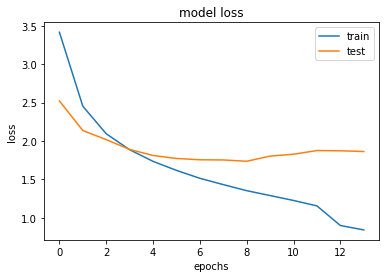

In [24]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','test'], loc='upper right')
plt.show()

# Task 3. Fine-tune pre-trained model via 🤗

Substantial gains can be achieved by pre-training on a large corpus of text followed by fine-tuning a specific task. In this task, we will take advantage of [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/pdf/1910.01108.pdf), [`distillbert-uncased`](https://huggingface.co/distilbert-base-uncased) specifically, and fine-tune it on the 20 Newsgroups dataset.

1. Install [`Transformers`](https://huggingface.co/docs/transformers) and [`datasets`](https://huggingface.co/docs/datasets/index).

In [25]:
! pip install -U -q transformers datasets

1. Import the library and check its version.


In [26]:
import transformers
print(transformers.__version__)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

4.23.1


In [27]:
#pd.DataFrame(train['data'],train['target'], columns=['text','label']).head()
type(train)

sklearn.utils.Bunch

1. Create `Dataset` objects for train / validation / test sets that are better compatible with the `Transformers` API.

    You can first create a `pd.DataFrame` with two fields: `text` and `label` with `data` and `target` from `train`. Then, call the `Dataset.from_pandas()` method to create a `Dataset` object and save it to `train_ds`. 

    Do the same for test set. 

In [28]:
from datasets import Dataset

df= pd.DataFrame()
df['text'] = train['data']
df['label'] =train['target']

train_ds = Dataset.from_pandas(df)# YOUR CODE HERE

df= pd.DataFrame()
df['text'] = test['data']
df['label'] =test['target']

test_ds  = Dataset.from_pandas(df)# YOUR CODE HERE

1. Cast column `label` as `datasets.features.ClassLabel` object using [`class_encode_column`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.class_encode_column) for both `train_ds` and `test_ds`.

In [29]:
train_ds = train_ds.class_encode_column('label')# YOUR CODE HERE
test_ds = test_ds.class_encode_column('label') # YOUR CODE HERE

Stringifying the column:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}

1. Create the validation set by apply [`train_ds.train_test_split()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.train_test_split). Similarly, set the test size to 0.1, and set the random state to 19. Make sure the split is stratified by column `label`. Save the result to `train_dsd` as the result is a DatasetDict object.

    Here's another way to do train / validation / test split: [ref](https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090/2)

In [31]:
train_dsd = train_ds.train_test_split(test_size=0.1, seed=19, stratify_by_column="label") # YOUR CODE HERE

In [32]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Yet the 'test' set inside `train_dsd` is meant for validation, the following code will rename the test set to validation and add a new DataSet object for the test set.

In [33]:
train_dsd['validation'] = train_dsd['test']
train_dsd['test'] = test_ds

In [34]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Load the DistilBERT tokenizer to process the text. 
    
    Use [`AutoTokenizer`](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.AutoTokenizer) to load the tokenizer for the given `model_checkpoint`. 

In [35]:
from transformers import AutoTokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) # YOUR CODE HERE

1. Create a preprocessing function to tokenize text, truncate and pad sequences to be no longer than DistilBERT’s maximum input length:

In [36]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=MAX_LEN)

1. Use 🤗 Datasets [map](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.map) function to apply the preprocessing function over the entire dataset. You can speed up the map function by setting `batched=True` to process multiple elements of the dataset at once:

In [37]:
tokenized_text = train_dsd.map(preprocess_function, batched =True) # YOUR CODE HERE

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [38]:
tokenized_text

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1132
    })
})

1. Use [DataCollatorWithPadding](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/data_collator#transformers.DataCollatorWithPadding) to create a batch of examples. Set the type of Tensor to return as 'tf' as we will fine-tune the model in TensorFlow.

In [43]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer,return_tensors = 'tf') # YOUR CODE HERE


In [44]:
tokenized_text["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [45]:
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='tf')

1. To fine-tune a model in TensorFlow, start by converting datasets to the `tf.data.Dataset` format with `to_tf_dataset`. 

    Specify inputs and labels in columns, whether to shuffle the dataset order, batch size, and the data collator:

In [46]:
BATCH_SIZE = 16

tf_train_set = tokenized_text["train"].to_tf_dataset(
    columns= [ 'input_ids', 'attention_mask'],  # YOUR CODE HERE
    label_cols=["label"],
    shuffle= True,  # YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
tf_validation_set = tokenized_text["validation"].to_tf_dataset(
    columns= [  'input_ids', 'attention_mask'],    # YOUR CODE HERE
    label_cols=["label"],
    shuffle= False,    # YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    )
tf_test_set = tokenized_text["test"].to_tf_dataset(
    columns= ['input_ids', 'attention_mask'],   # YOUR CODE HERE
    label_cols=["label"],
    shuffle= False,   # YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    )

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1. Set up an optimizer function, learning rate schedule, and some training hyperparameters:

In [47]:
from transformers import create_optimizer

EPOCHS = 5
batches_per_epoch = len(tokenized_text["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * EPOCHS)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

1. Load DistilBERT with  [TFAutoModelForSequenceClassification](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.TFAutoModelForSequenceClassification) along with the number of expected labels:

In [51]:
from transformers import TFAutoModelForSequenceClassification

my_bert = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=NUM_LABELS)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_20', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

1. Don't forget to configure the model for training with [`compile`](https://keras.io/api/models/model_training_apis/#compile-method):

In [52]:
my_bert.compile(optimizer=optimizer,  metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1. Finally, let the fine-tuning start!

    You may run into CoLab's usage limit, feel free to lower the parameter `epochs` to 3; even so, it could take ~10 minutes. 

In [53]:
%%time
# YOUR CODE 
my_bert.fit(tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3
637/637 [==============================] - 295s 446ms/step - loss: 1.3039 - accuracy: 0.6852 - val_loss: 0.5773 - val_accuracy: 0.8445
Epoch 2/3
637/637 [==============================] - 285s 447ms/step - loss: 0.4157 - accuracy: 0.8886 - val_loss: 0.4093 - val_accuracy: 0.8834
Epoch 3/3
637/637 [==============================] - 285s 447ms/step - loss: 0.2232 - accuracy: 0.9415 - val_loss: 0.3422 - val_accuracy: 0.9108
CPU times: user 10min 26s, sys: 18.5 s, total: 10min 45s
Wall time: 15min 39s


1. As you are waiting for the fine-tuning to finish, how many parameters does DistilBERT have? How about BERT? What is the world's largest open Multilingual Language Model as of July 2022? (hint: 🌸) 

    YOUR ANSWER HERE

The BERT-Base is one-third of the BERT-Large containing 110M parameters, whereas DistilBERT is even 40% smaller than that. The largest language model with its 176 billion parameters is BLOOM - able to generate text in 46 natural languages and 13 programming languages. For almost all of them, such as Spanish, French and Arabic, BLOOM will be the first language model with over 100B parameters ever created. 

1. Evaluate the model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy shall be around 0.84).

In [54]:
bert_loss, bert_acc = my_bert.evaluate(tf_test_set) # YOUR CODE HERE

471/471 [==============================] - 69s 146ms/step - loss: 0.5639 - accuracy: 0.8444


In [55]:
bert_loss

0.5639010667800903

In [56]:
bert_acc

0.844397246837616

1. Optional. If you are happy with the result, you can save the model to a file. 
    
    One easy way to do it is to use [`save_pretrained()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.save_pretrained) to save the model to a file. Check [Export 🤗 Transformers Models](https://huggingface.co/docs/transformers/serialization) for deployment options.

In [57]:
tokenizer.save_pretrained("local-tf-checkpoint")
my_bert.save_pretrained("local-tf-checkpoint")

### **Essay Questions**

1. In the transformer architecture in the paper "Attention Is All You Need", how does Multi-head Attention work?

Transformers are powerful owing to their attention mechanism and the driving force for transformers are multi-head attention that is based on self- attention. Attention is where more weightage is given to certain key words rather than all words in an input sequence. In self attention, weightage is given to the context in which the word appears, while allowing for these words to interact with each other. 
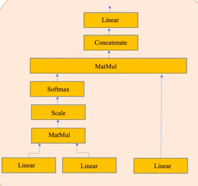

In multi-head attention, the input & positional embedding is fed three times to 3 different linear layers- each representing 'query', 'key' & 'value' layers. Each of these 3 layers have their own distinct weights- this is where self-attention comes into play. The dot product of these matrices result in query, key & value matrices. A matrix multiplication of the Query & key matrix yields the attention filter on while the scaling (divide values by square root of key vector) and softmax tranformation (squash values between 0 and 1) is applied. Mulitplying this attention filter with the third value matrix yields a reduced dimension matrice with most important information/ eliminated noise. Tranformers don't learn just 1 attention filter but multiple, each learning different linguistic phenomena (in 'attention is all you need' the authors use a total of 8 attention heads but that can be computaionally expensive.

2. What is the main idea behind Positional Encoding?

Positional encoding describes the location or position of an entity in a sequence so that each position is assigned a unique representation. While LSTM's were recurrent and the order of input indicated its position, transformers are much faster as they process inputs parrallely, which means they lose the positional information of the text. A simple index of position doesnt cut it as a word in 50'th position would ufairly enlarge the output vector owing to multiplication and the dot product of inverse position (so the max is always 1) doesnt cut it as well as sentences are always varying in length and position of 2 is not consistent with this method across sentences. The authors of this paper came up with a clever way of using both sine and cosine wave frequencies to denote positional embeddings as words far apart do fall on different frequencies.

3. What is EarlyStopping and why do we use it?

Early stopping is a form of regularization used to avoid overfitting. Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping allows us to specify an arbitrary number of training epochs and stop training once the model performance stops improving on a hold out validation dataset. Use Callbacks in Keras to enforce this functionality.

4. How would explain what a transformer model is to business stakeholders (at a high level)?

The transformer consists of the encoder-decoder architecture but what sets the transformers apart is its attention-mechanism - look at an input sequence and decide at each step which other parts of the sequence are important, i.e., besides conveying the translation, keywords that are important to the semantics of the sentenceare provided to the decoder for more context. In short, the attention-mechanism takes into account several other inputs at the same time and decides which ones are important by attributing different weights to those inputs. The Decoder will then take as input the encoded sentence and the weights provided by the attention-mechanism.

With Recurrent Neural Networks (RNN’s) we used to treat sequences sequentially to keep the order of the sentence in place. The computations were performed sequentially and hence slower. With transformers, the data is not sequential anymore, the inputs are now both input and position embeddings together fed three times spearately to linear matrices to obtain 'query', 'key' and 'value' matrices. The dot product, scaling and softmax transformed output yields a reduced dimension output that has only the pertinent information ready to pass to decoder. The process described above happens in the  mulit-head attention layer. The decoder takes both the output from encoder and output text as its input and we first have the masked multi head attention- as here in decoding stage, we predict one word (token) after another and so the self-attention layer needs to be modified in order to consider only the output sentence that has been generated so far (hence the mask). This mask will change for every new token we compute.

Encoder-Decoder attention: The attention matrix generated by the encoder is passed to another attention layer alongside the result of the previous Masked Multi-head attention block in this stage. The intuition behind the encoder-decoder attention layer is to combine the input and output sentence. The encoder’s output encapsulates the final embedding of the input sentence and is similar to a database. So we will use the encoder output to produce the Key and Value matrices. On the other hand, the output of the Masked Multi-head attention block contains the so far generated new sentence and is represented as the Query matrix in the attention layer (akin to 'search' query in a database).

# Acknowledgement & Reference

- Part of the notebook is adapted from [Text Classification - Attention](https://www.kaggle.com/code/ritvik1909/text-classification-attention)
- Part of the notebook is adapted from [Fine-tune a pretrained model with Hugging Face](https://huggingface.co/docs/transformers/training)
- We used accuracy for metric, check out [Comprehensive Guide to Multiclass Classification Metrics](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd).
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [Hugging Face: State-of-the-Art Natural Language Processing in ten lines of TensorFlow 2.0](https://medium.com/tensorflow/using-tensorflow-2-for-state-of-the-art-natural-language-processing-102445cda54a)
- More readings on Transformers, check the Course Materials section on [CS25: Transformers United](https://web.stanford.edu/class/cs25/)
